In [1]:
import pipeline


In [2]:
df = pipeline.read_load('/home/erhla/Downloads/credit-data.csv')
pipeline.explore(df, ['PersonID','zipcode']) 

VARIABLE: SeriousDlqin2yrs 
 count    41016.000000
mean         0.161400
std          0.367904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64 

VARIABLE: RevolvingUtilizationOfUnsecuredLines 
 count    41016.00000
mean         6.37587
std        221.61895
min          0.00000
25%          0.03431
50%          0.18973
75%          0.66716
max      22000.00000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64 

VARIABLE: age 
 count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64 

VARIABLE: NumberOfTime30-59DaysPastDueNotWorse 
 count    41016.000000
mean         0.589233
std          5.205628
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime30-59DaysPast

## Load and Explore data

The above cell loads (using pd.read_csv) and explore the data set. Exploration is facilitating by temporarily dropping descriptive columns before printing pd.describe() for each column. From this output we can see about 16.1% of entries in the database have the outcome SeriouesDlqin2yrs.  Additionally, we can see that from variables such as revolving utilization, number of times past due, debt ratio, and monthly income that  most of the variables have some entries with severe financial distress (represented by the difference between the 75% quantile and the maximal values).

Additionally, some of these variables are correlated. Number of times past due 30-59 days, 60-89 days, and 90+ days are highly correlated. A more serious analysis might consider dropping some of these variables. Number of Real Estate Loans is also correlated with number of open credit lines, but at a less significant factor.

Finally, by looking at values greater than five standard deviations from variable means, some entries are also identified as possible outliers. Considering the nature of this data set (one capturing financial distress), these outliers were not removed as they are indiciative of the target outcome variable. Number of real estate loans had the most values identified at 154.

Below, you can see a simple percent comparision of attribute means between those with SeriousDlqin2yrs and those not.

In [3]:
no_df = df[df['SeriousDlqin2yrs'] == 0]
yes_df = df[df['SeriousDlqin2yrs'] == 1]

print('percent change in variable name comparing outcome = yes to outcome = no')
(yes_df.agg('mean') - no_df.agg('mean')) / yes_df.agg('mean')

percent change in variable name comparing outcome = yes to outcome = no


PersonID                               -0.626990
SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines   -0.680593
age                                    -0.151899
zipcode                                -0.000024
NumberOfTime30-59DaysPastDueNotWorse    0.894884
DebtRatio                              -0.163144
MonthlyIncome                          -0.211271
NumberOfOpenCreditLinesAndLoans        -0.071213
NumberOfTimes90DaysLate                 0.950901
NumberRealEstateLoansOrLines           -0.034025
NumberOfTime60-89DaysPastDueNotWorse    0.947365
NumberOfDependents                      0.212325
dtype: float64

In [4]:
df = pipeline.preprocess(df, ['PersonID','zipcode']) 

7974 nas filled for MonthlyIncome
1037 nas filled for NumberOfDependents


In [5]:
df = pipeline.generate_features(df, 'SeriousDlqin2yrs', 'dummy')
df = pipeline.generate_features(df, 'MonthlyIncome', 'discretized', 10)
df['zipcode'] = df['zipcode'].astype('category')

SeriousDlqin2yrs has values:  [0 1]
dummy created for SeriousDlqin2yrs
MonthlyIncome discretized


## Preprocess and Generate Features

Preprocessing at this stage is simple; merely filling na values with variable medians. The counts of nas can be seen above.

Generating features is more complex. generate_features replaces a column with a discretized or dummy version. Discretizing works by splitting a variable up into quantile bins (so MonthlyIncome has 10 possible values/bins for each decile). Setting a variable as dummy simply converts a column into a categorical variable and updates the category name. To create dummy variables for columns with more than two values is partially implemented and generates multiple new columns.

In [6]:

model, x_test, y_test = pipeline.build_classifier(df, 'SeriousDlqin2yrs', 0.1, 4, 20)
pipeline.evaluate_classifier(model, x_test, y_test)

model has accuracy 0.9439297903461726


## Build Classifier and Evaluate

These stages of the pipeline build the model using sklearn.tree.DecisionTreeClassifier. Withholding ten percent of the data as testing data, this block builds a decision tree with max_depth=4 and min_split_size=20.

This model evaluated on accuracy against the testing data has an accuracy of about 95%. Below is an image of the decision tree produced. An approximate table of contents for the features used to split the tree is provided below the model.

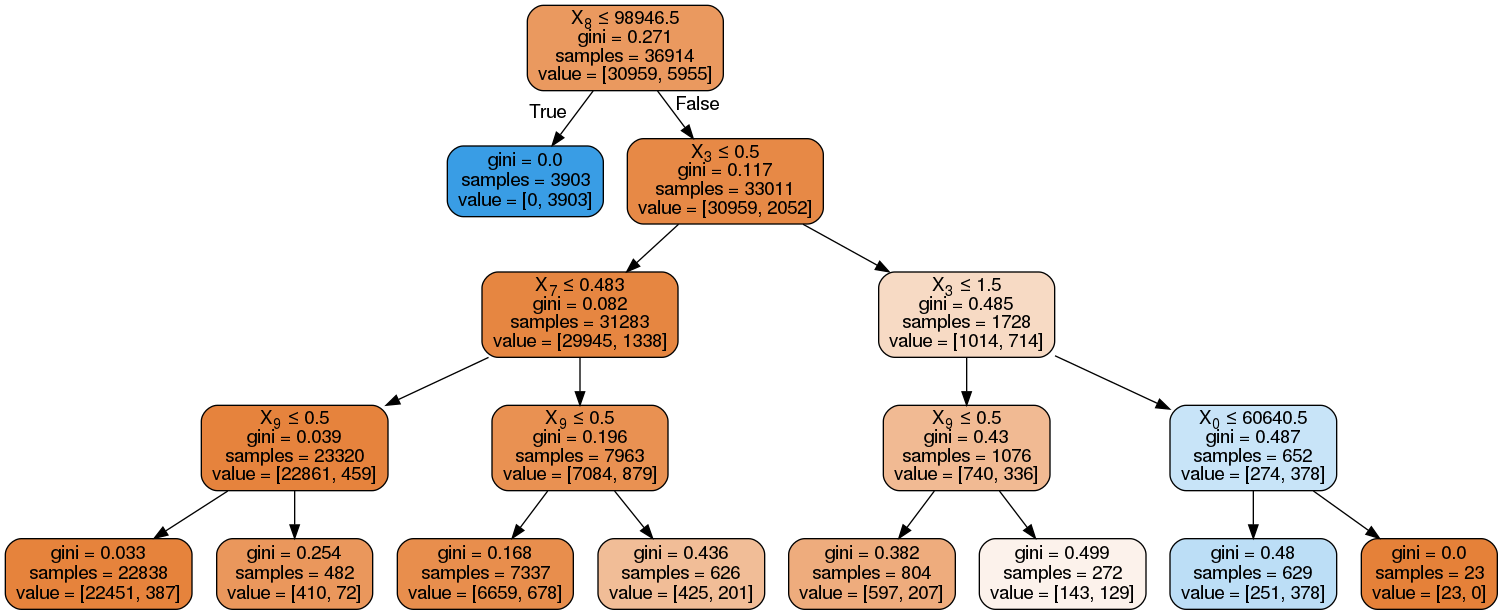

In [7]:
#see https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [8]:
for i, col in enumerate(x_test.columns):
    print('X_',i+1, col)

X_ 1 zipcode
X_ 2 DebtRatio
X_ 3 NumberRealEstateLoansOrLines
X_ 4 NumberOfTimes90DaysLate
X_ 5 age
X_ 6 NumberOfDependents
X_ 7 NumberOfOpenCreditLinesAndLoans
X_ 8 RevolvingUtilizationOfUnsecuredLines
X_ 9 PersonID
X_ 10 NumberOfTime60-89DaysPastDueNotWorse
X_ 11 NumberOfTime30-59DaysPastDueNotWorse
X_ 12 MonthlyIncome
